In [114]:
import copy
import pickle
import numpy as np

def LoadBatch(filename):
    """ Copied from the dataset website """
    with open('Datasets/' + filename, 'rb') as fo:
        dataset_dict = pickle.load(fo, encoding='bytes')
 
    return dataset_dict


def load(filename):
    data = LoadBatch(filename)
    
    X = data[b'data'].astype(np.float32).reshape(-1, 3072).T / 255
    y = np.array(data[b'labels']).astype(np.int32)
    
    Y = np.zeros((10, y.shape[0]), dtype=np.float32)
    for i, label in enumerate(y):
        Y[label, i] = 1
    
    return X, Y, y + 1


def initialize_weights(shapes_list):
    np.random.seed(369)

    weights = []
    biases = []

    for shape in shapes_list:
        W = np.random.normal(0, 0.001, size=(shape[0], shape[1]))
        b = np.zeros(shape=(shape[0], 1))

        weights.append(W)
        biases.append(b)

    return weights, biases

def normalize_data(train, validation, test):
    # Compute the mean and standard deviation of the training data
    train_mean = np.mean(train, axis=1, keepdims=True)
    train_std = np.std(train, axis=1, keepdims=True)

    # Normalize the training, validation and test data
    train_norm = (train - train_mean) / train_std
    validation_norm = (validation - train_mean) / train_std
    test_norm = (test - train_mean) / train_std

    return train_norm, validation_norm, test_norm



In [98]:

def softmax(X, theta=1.0, axis=None):

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1:
        p = p.flatten()

    return p

def EvaluateClassifier(X, W, b):


    intermediate_outputs = [] # s's
    intermediate_activations = [] #h's

    s = np.dot(W[0], X) + b[0]
    intermediate_outputs.append(s)
    h = np.maximum(s, 0)
    intermediate_activations.append(h)

    for i in range(1, len(W) - 1):

        s = np.dot(W[i], intermediate_activations[-1]) + b[i]
        intermediate_outputs.append(s)
        h = np.maximum(s, 0)
        intermediate_activations.append(h)

    s = np.dot(W[-1], intermediate_activations[-1]) + b[-1]
    p = softmax(s, axis=0)

    return p, intermediate_activations, intermediate_outputs

In [58]:
def ComputeAccuracy(X, y, weights, biases):
    """
    Computes the accuracy of the feed-forward 2-layer network

    :param X: Input data
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers

    :return: Accuracy performance of the neural network.
    """
    p, _, _ = EvaluateClassifier(X, weights, biases)
    predictions = np.argmax(p, axis=0)

    accuracy = round(np.sum(np.where(predictions - y == 0, 1, 0)) * 100 / len(y), 2)

    return accuracy

In [76]:
def ComputeCost(X, Y, W, b, lamda):
    p, _, _ = EvaluateClassifier(X, W, b)

    cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum() / float(X.shape[1])

    weight_sum = 0
    for weight in W:
        weight_sum += np.power(weight, 2).sum()

    cost = cross_entropy_loss + lamda * weight_sum

    return cost, cross_entropy_loss

In [81]:
from tqdm import tqdm

def ComputeGradsNumSlow(X, Y, weights, biases, lamda, start_index=0, h=1e-5):
  
    grad_weights = []
    grad_biases = []
    
    for layer_index in range(start_index, len(weights)):
        
        W = weights[layer_index]
        b = biases[layer_index]
        
        grad_W = np.zeros(W.shape)
        grad_b = np.zeros(b.shape)

        for i in tqdm(range(b.shape[0])):
            b_try = np.copy(b)
            b_try[i, 0] -= h
            temp_biases = biases.copy()
            temp_biases[layer_index] = b_try
            c1, _ = ComputeCost(X, Y, weights, temp_biases, lamda)
            b_try = np.copy(b)
            b_try[i, 0] += h
            temp_biases = biases.copy()
            temp_biases[layer_index] = b_try
            c2, _ = ComputeCost(X, Y, weights, temp_biases, lamda)

            grad_b[i, 0] = (c2 - c1) / (2 * h)

        grad_biases.append(grad_b)

        for i in tqdm(range(W.shape[0])):
            for j in range(W.shape[1]):
                W_try = np.copy(W)
                W_try[i, j] -= h
                temp_weights = weights.copy()
                temp_weights[layer_index] = W_try
                c1, _ = ComputeCost(X, Y, temp_weights, biases, lamda)
                W_try = np.copy(W)
                W_try[i, j] += h
                temp_weights = weights.copy()
                temp_weights[layer_index] = W_try
                c2, _ = ComputeCost(X, Y, temp_weights, biases, lamda)

                grad_W[i, j] = (c2 - c1) / (2 * h)

        grad_weights.append(grad_W)

    return grad_weights, grad_biases

In [161]:
"""def ComputeGradients(X, Y, weights, biases, p, outputs, activations, lamda):


    # Back-propagate output layer at first

    weight_updates = []
    bias_updates = []

    g = p - Y
    bias_updates.append(g.sum(axis=1).reshape(biases[-1].shape))
    weight_updates.append(np.dot(g, activations[-1].T))

    for i in reversed(range(len(weights) -1)):
    # Back-propagate the gradient vector g to the layer before

        g = np.dot(g.T, weights[i+1])
        ind = 1 * (outputs[i] > 0)
        g = g.T * ind

        if i == 0:
            weight_updates.append(np.dot(g, X.T))
        else:
            weight_updates.append(np.dot(g, activations[i-1].T))

        bias_updates.append(np.sum(g, axis=1).reshape(biases[i].shape))

    for elem in weight_updates:
        elem /= X.shape[1]

    for elem in bias_updates:
        elem /= X.shape[1]

    # Reverse the updates to match the order of the layers
    weight_updates = list(reversed(weight_updates)).copy()
    bias_updates = list(reversed(bias_updates)).copy()

    # Add regularizers
    for index in range(len(weight_updates)):
        weight_updates[index] += 2*lamda * weight_updates[index]

    return weight_updates, bias_updates"""


def ComputeGradients(X, Y, weights, biases, p, outputs, activations, lamda):
    # Back-propagate output layer at first
    weight_updates = []
    bias_updates = []

    g = p - Y
    bias_updates.append(g.sum(axis=1).reshape(biases[-1].shape))
    weight_updates.append(np.dot(g, activations[-1].T) / X.shape[1] + 2*lamda * weights[-1])

    for i in reversed(range(len(weights) -1)):
    # Back-propagate the gradient vector g to the layer before
        g = np.dot(g.T, weights[i+1])
        ind = 1 * (outputs[i] > 0)
        g = g.T * ind

        if i == 0:
            weight_updates.append(np.dot(g, X.T) / X.shape[1] + 2*lamda * weights[i])
        else:
            weight_updates.append(np.dot(g, activations[i-1].T) / X.shape[1] + 2*lamda * weights[i])

        bias_updates.append(np.sum(g, axis=1).reshape(biases[i].shape) / X.shape[1])

    # Reverse the updates to match the order of the layers
    weight_updates = list(reversed(weight_updates)).copy()
    bias_updates = list(reversed(bias_updates)).copy()

    return weight_updates, bias_updates


In [62]:
def check_similarity(grad_weights, grad_biases, num_weights, num_biases):
    for layer_index in range(len(grad_weights)):

        print('-----------------')
        print(f'Layer no. {layer_index+1}:')

        weight_abs = np.abs(grad_weights[layer_index] - num_weights[layer_index])
        bias_abs = np.abs(grad_biases[layer_index] - num_biases[layer_index])

        weight_nominator = np.average(weight_abs)
        bias_nominator = np.average(bias_abs)

        grad_weight_abs = np.absolute(grad_weights[layer_index])
        grad_weight_num_abs = np.absolute(num_weights[layer_index])

        grad_bias_abs = np.absolute(grad_biases[layer_index])
        grad_bias_num_abs = np.absolute(num_biases[layer_index])

        sum_weight = grad_weight_abs + grad_weight_num_abs
        sum_bias = grad_bias_abs + grad_bias_num_abs

        print(f'Deviation on weight matrix: {weight_nominator / np.amax(sum_weight)}')
        print(f'Deviation on bias vector: {bias_nominator / np.amax(sum_bias)}')

In [63]:
# initialize weights for layer 2

W, b = initialize_weights([(50, 3072), (10, 50)])

# load data

X_train, Y_train, y_train = load('data_batch_1')
X_val, Y_val, y_val = load('data_batch_2')
X_test, Y_test, y_test = load('test_batch')

#training_set, validation_set = [X_training_1, Y_training_1, y_training_1], [X_training_2, Y_training_2, y_training_2]

lamda = 0
grad_weights_num_2, grad_biases_num_2 = ComputeGradsNumSlow(X_train[:, :100], Y_train[:, :100], W, b, lamda,start_index=0, h=1e-5)

p, activations, outputs = EvaluateClassifier(X_train[:, :100], W, b)

grad_weight_anal_2, grad_biases_anal_2 = ComputeGradients(X_train[:, :100], Y_train[:, :100], W, b, p, outputs, activations, lamda)

check_similarity(grad_weight_anal_2, grad_biases_anal_2, grad_weights_num_2, grad_biases_num_2)

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

-----------------
Layer no. 1:
Deviation on weight matrix: 3.537789730714426e-06
Deviation on bias vector: 4.804673257373751e-05
-----------------
Layer no. 2:
Deviation on weight matrix: 1.7169938875554778e-09
Deviation on bias vector: 1.088192986634812e-10


In [67]:
# initialize weights for layer 3

W, b = initialize_weights([(50, 3072), (20, 50), (10, 20)])

grad_weights_num_3, grad_biases_num_3 = ComputeGradsNumSlow(X_train[:, :100], Y_train[:, :100], W, b, lamda,start_index=0, h=1e-5)
p, activations, outputs = EvaluateClassifier(X_train[:, :100], W, b)

grad_weight_anal_3, grad_biases_anal_3 = ComputeGradients(X_train[:, :100], Y_train[:, :100], W, b, p, outputs, activations, lamda)

check_similarity(grad_weight_anal_3, grad_biases_anal_3, grad_weights_num_3, grad_biases_num_3)


(50, 3072)
(20, 50)
(10, 20)


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

-----------------
Layer no. 1:
Deviation on weight matrix: 1.909308752100319e-05
Deviation on bias vector: 0.00018776902601364833
-----------------
Layer no. 2:
Deviation on weight matrix: 8.874444094428644e-05
Deviation on bias vector: 0.00786963129832104
-----------------
Layer no. 3:
Deviation on weight matrix: 4.6777730805879986e-07
Deviation on bias vector: 1.3404075883253205e-10


In [68]:
# initailize weights for layer 4

W, b = initialize_weights([(50, 3072), (20, 50), (15, 20), (10, 15)])

grad_weights_num_4, grad_biases_num_4 = ComputeGradsNumSlow(X_train[:, :100], Y_train[:, :100], W, b, lamda, start_index=0, h=1e-5)

p, activations, outputs = EvaluateClassifier(X_train[:, :100], W, b)

grad_weight_anal_4, grad_biases_anal_4 = ComputeGradients(X_train[:, :100], Y_train[:, :100], W, b, p, outputs, activations)

check_similarity(grad_weight_anal_4, grad_biases_anal_4, grad_weights_num_4, grad_biases_num_4)

(50, 3072)
(20, 50)
(15, 20)
(10, 15)


100%|██████████| 10/10 [00:01<00:00,  5.30it/s]


-----------------
Layer no. 1:
Deviation on weight matrix: 0.0015567897724680004
Deviation on bias vector: 0.0011173947510935416
-----------------
Layer no. 2:
Deviation on weight matrix: 0.00015078653358474331
Deviation on bias vector: 0.008463577432205016
-----------------
Layer no. 3:
Deviation on weight matrix: 0.00016983758312897303
Deviation on bias vector: 0.14491214972611224
-----------------
Layer no. 4:
Deviation on weight matrix: 0.00010558898123060132
Deviation on bias vector: 1.3216242558187657e-10


In [162]:


def train_network_cyclical(X_train, Y_train, X_val, Y_val, weights, biases, lambda_, n_batch, eta_min, eta_max, n_s, n_epochs, y_train, y_val, X_test, y_test):
    train_losses = []
    val_losses = []
    train_costs = []
    val_costs = []

    test_accs = []
    train_accs = []

    t = 1
    eta_history = []
    update_step_history = []

    num_steps = X_train.shape[1] // n_batch
    best_validation_set_accuracy = 0

    for epoch in tqdm(range(n_epochs)):
        for j in range(int(num_steps)):
            t = t % (2 * n_s)  
            # cyclic learning rate
            if t <= n_s:
                eta = eta_min + (t / n_s) * (eta_max - eta_min)
            else:
                eta = eta_max - ((t - n_s) / n_s) * (eta_max - eta_min)

            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            indices = slice(j_start, j_end)
            X_batch = X_train[:, indices]
            Y_batch = Y_train[:, indices]
            
            p, outputs, activations = EvaluateClassifier(X_batch, weights, biases)
            
            weight_updates, bias_updates = ComputeGradients(X_batch, Y_batch, weights, biases, p, outputs, activations, lambda_)
            
            for i in range(len(weights)):
                weights[i] -= eta * weight_updates[i]
                biases[i] -= eta * bias_updates[i]
        validation_set_accuracy = ComputeAccuracy(X_val, y_val, weights, biases)

        if validation_set_accuracy > best_validation_set_accuracy:

            best_weights = weights
            best_biases = biases
            best_validation_set_accuracy = validation_set_accuracy


        # Calculate and store the costs at every update step
        if n_epochs % 10 == 0:

            cost_train, _ = ComputeCost(X_train, Y_train, best_weights, best_biases, lambda_)
            cost_val, _= ComputeCost(X_val, Y_val, best_weights, best_biases, lambda_)
            train_costs.append(cost_train)
            val_costs.append(cost_val)

            _, loss_train = ComputeCost(X_train, Y_train, best_weights, best_biases, lambda_)
            _, loss_val = ComputeCost(X_val, Y_val, best_weights, best_biases, lambda_)
            train_losses.append(loss_train)
            val_losses.append(loss_val)


            train_accuracy = ComputeAccuracy(X_train, y_train, best_weights, best_biases)
            train_accs.append(train_accuracy)
            test_accuracy = ComputeAccuracy(X_test, y_test, best_weights, best_biases)
            test_accs.append(test_accuracy)
        
        t += 1

    return best_weights, best_biases, train_losses, val_losses, train_costs, val_costs, train_accs, test_accs, eta_history, update_step_history



In [148]:
def initialize_momentum(arrays):
    """
    Initializes the momentum arrays to zero numpy arrays.
    
    :param matrices: Weights or bias that need corresponding momentum arrays.
    :return: Numpy zeros for each layer of the same shape
    """
    momentum_matrices = []
    for elem in arrays:
        momentum_matrices.append(np.zeros(elem.shape))
    return momentum_matrices

def add_momentum(weights, grad_weights, momentum_weights, biases, grad_biases, momentum_biases, eta, momentum_term):
    """
    Add momentum to an array (weight or bias) of the network.

    :param weights: The weight matrices of the k layers.
    :param grad_weights: The gradient updatea of the weights.
    :param momentum_weights: Momentum arrays (v) of the weights.
    :param biases: The bias vector of the k layers.
    :param grad_biases: The gradient updates for the biases.
    :param momentum_biases: Momentum vectors (v) of the weights.
    :param eta: Learning rate of the network.
    :param momentum_term: Amount of momentum to be taken into account in the updates.

    :return: Updated weights and biases of the network with momentum contribution, updated momentumm arrays for the
             weights and biases of the network.
    """

    updated_weights = []
    updated_biases = []

    for index in range(len(weights)):

        new_momentum_weight = momentum_term * momentum_weights[index] + eta * grad_weights[index]
        momentum_weights[index] = new_momentum_weight
        updated_weights.append(weights[index] - new_momentum_weight)

        new_momentum_bias = momentum_term * momentum_biases[index] + eta * grad_biases[index]
        momentum_biases[index] = new_momentum_bias
        updated_biases.append(biases[index] - new_momentum_bias)


    return updated_weights, updated_biases, momentum_weights, momentum_biases

def MiniBatchGDwithMomentum(training_set, validation_set, GDparams, weights, biases ,momentum_term):
    """
    Performs mini batch-gradient descent computations.

    :param training_set: Training data.
    :param validation_set: Validation data.
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs, amount of regularization to be applied)
    :param weights: Weight matrices of the k layers
    :param biases: Bias vectors of the k layers

    :return: The weight and bias matrices learnt (trained) from the training process,
             loss in training and validation set, accuracy evolution in training and validation set.
    """
    [number_of_mini_batches, eta, epoches, regularization_term] = GDparams

    [X, Y, y], [X_validation, Y_validation, y_validation] = training_set, validation_set

    train_loss_evolution, validation_loss_evolution = [], []
    train_accuracy_evolution, validation_accuracy_evolution = [], []

    momentum_weights, momentum_biases = initialize_momentum(weights), initialize_momentum(biases)

    original_training_cost, _ = ComputeCost(X, Y, weights, biases, regularization_term)
    
    best_validation_set_accuracy = 0

    for _ in tqdm(range(epoches)):
        # for epoch in range(epoches):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            p, intermediate_activations, intermediate_outputs = EvaluateClassifier(X[:, start:end], weights, biases)

            grad_weights, grad_biases = ComputeGradients(X[:, start:end], Y[:, start:end], weights, biases, p, intermediate_outputs, intermediate_activations, regularization_term)

            weights, biases, momentum_weights, momentum_biases = add_momentum(weights, grad_weights, momentum_weights, biases, grad_biases, momentum_biases, eta, momentum_term)

        validation_set_accuracy = ComputeAccuracy(X_validation, y_validation, weights, biases)

        if validation_set_accuracy > best_validation_set_accuracy:

            best_weights = weights
            best_biases = biases
            best_validation_set_accuracy = validation_set_accuracy

        epoch_cost, _ = ComputeCost(X, Y, weights, biases, regularization_term)
        if epoch_cost > 3 * original_training_cost:
            break
        val_epoch_cost,_ = ComputeCost(X_validation, Y_validation, weights, biases, regularization_term)

        train_loss_evolution.append(epoch_cost)
        validation_loss_evolution.append(val_epoch_cost)
        train_accuracy_evolution.append(ComputeAccuracy(X, y, weights, biases))
        validation_accuracy_evolution.append(ComputeAccuracy(X_validation, y_validation, weights, biases))

        # Decay the learning rate
        eta *= 0.95

    return best_weights, best_biases, [train_loss_evolution, validation_loss_evolution], [train_accuracy_evolution, validation_accuracy_evolution]

In [85]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

In [149]:
# tersting if I get same results as in the assignment 2
X_train, Y_train, y_train = load('data_batch_1')
X_val, Y_val, y_val = load('data_batch_2')
X_test, Y_test, y_test = load('test_batch')

X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

W, b = initialize_weights([[50, 3072], [10, 50]])

lamda = 0.001 # change 
eta_min = 1e-5
eta_max = 1e-1
#n_s = 10
n_batch = 100
n_epochs = 10

GD_params = [n_batch, eta_min, n_epochs, lamda]

training_set = [X_train_norm, Y_train, y_train]
validation_set = [X_val_norm, Y_val, y_val]

#W, b,  train_losses, val_losses, train_costs, val_costs, train_accs, test_accs, eta_history, update_step_history = train_network_cyclical(
#    X_train_norm, Y_train, X_val_norm, Y_val, W, b, lamda, n_batch, eta_min, eta_max, n_s, n_epochs, y_train, y_val, X_test_norm, y_test)
W, b, training_cost, validation_cost =  MiniBatchGDwithMomentum(training_set, validation_set, GD_params, W, b, momentum_term=0.01)


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


In [150]:

# compute accuracy
acc = ComputeAccuracy(X_train_norm, y_test, W, b)
print(acc)

6.86


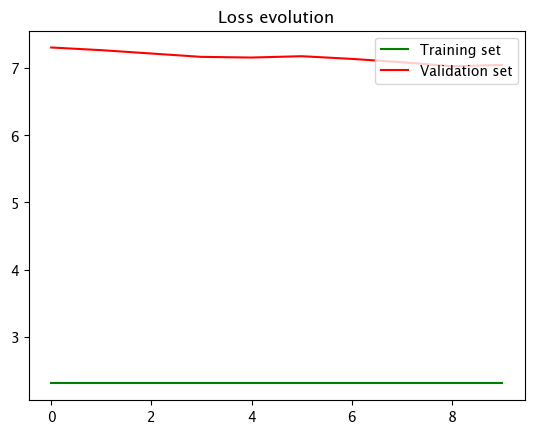

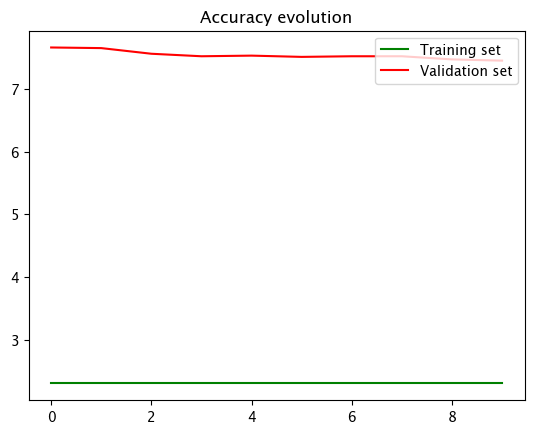

<Figure size 640x480 with 0 Axes>

In [153]:
import matplotlib.pyplot as plt
def visualize_plots(train, validation, display=False, title=None):
    """
    Visualization and saving plots (losses and accuracies) of the network.

    :param train: Loss of accuracy of the training data.
    :param validation: Loss of accuracy of the validation data.
    :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
    :param title: (Optional) Title of the plot.
    :param save_name: (Optional) name of the file to save the plot.
    :param save_path: (Optional) Path of the folder to save the plot in your local computer.

    :return: None

    """

    if title is not None:
        plt.title(title)

    plt.plot(train, 'g', label='Training set ')
    plt.plot(validation, 'r', label='Validation set')
    plt.legend(loc='upper right')

    if display:
        plt.show()

    plt.clf()

visualize_plots(training_cost[0], validation_cost[0], display=True, title='Loss evolution')

visualize_plots(training_cost[1], validation_cost[1], display=True, title='Accuracy evolution')

# load test data




In [165]:
X_train, Y_train, y_train = load('data_batch_1')
X_val, Y_val, y_val = load('data_batch_2')
X_test, Y_test, y_test = load('test_batch')

X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)


W, b = initialize_weights([[50, 3072], [10, 50]])

lamda = 0.001 # change 
eta_min = 1e-5
eta_max = 1e-1
n_s = 30
n_batch = 100
n_epochs = 30

best_weights, best_biases, train_losses, val_losses, train_costs, val_costs, train_accs, test_accs, eta_history, update_step_history = train_network_cyclical(
    X_train_norm, Y_train, X_val_norm, Y_val, W, b, lamda, n_batch, eta_min, eta_max, n_s, n_epochs, y_train, y_val, X_test_norm, y_test)

100%|██████████| 30/30 [02:11<00:00,  4.37s/it]


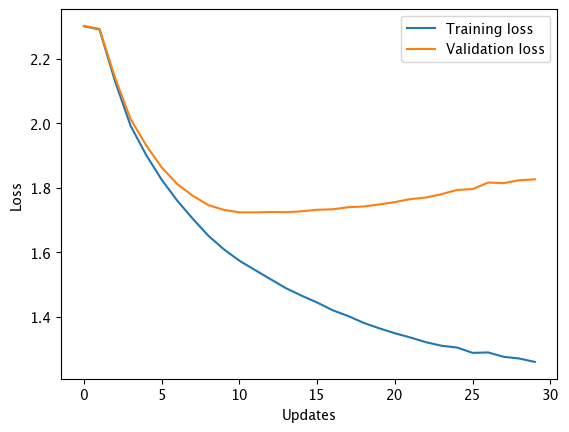

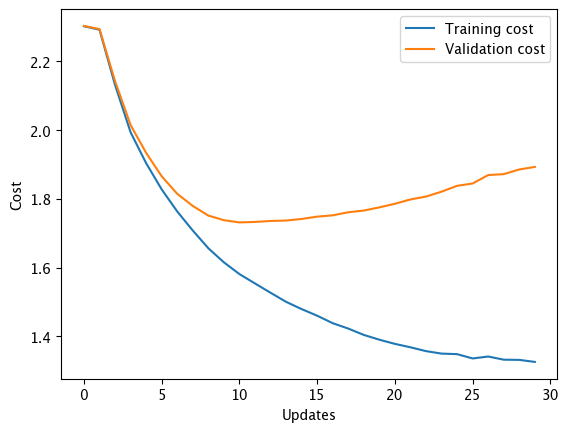

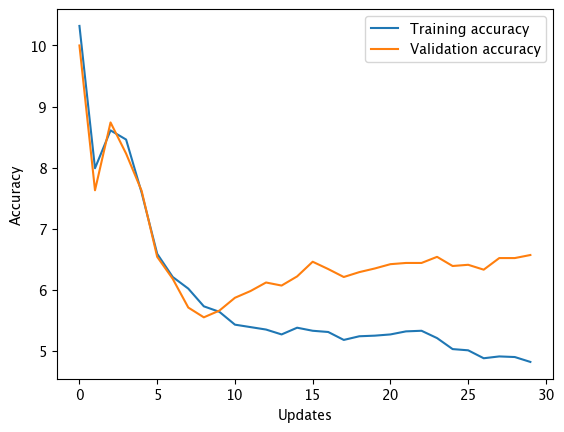

Final training accuracy: 4.82
Final validation accuracy: 6.57


In [166]:
#print("Final training accuracy:", train_accs[-1])

#import plt
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Updates')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Plot the training and validation cost
plt.plot(train_costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.xlabel('Updates')
plt.ylabel('Cost')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Validation accuracy')
plt.xlabel('Updates')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Print the final training loss
#print("Final training loss:", train_losses[-1])



#print accuracy
print("Final training accuracy:", train_accs[-1])
print("Final validation accuracy:", test_accs[-1])